In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import scipy

# Orange Trees: Non-linear growth curve

In [46]:
data = {'x' : [118, 484, 664, 1004, 1231, 1372, 1582], #Instants de mesure
        'Y' : [[30, 58, 87, 115, 120, 142, 145], [33, 69, 111, 156, 172, 203, 203], #Pour chacun des 5 arbres, on a les circonférences mesurées aux 7 instants x
            [30, 51, 75, 108, 115, 139, 140], [32, 62, 112, 167, 179, 209, 214],
            [30, 49, 81, 125, 142, 174, 177]]
        }         

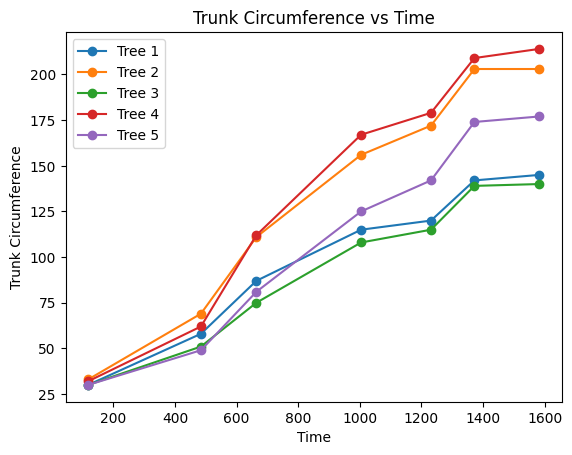

In [47]:
#Affichons l'évolution de la circonférence pour chaque arbre
for i in range(len(data['Y'])):
    plt.plot(data['x'], data['Y'][i], '-o', label='Tree '+str(i+1))
plt.legend()
plt.xlabel('Time')
plt.ylabel('Trunk Circumference')
plt.title('Trunk Circumference vs Time')
plt.show()

In [245]:
def MH_within_Gibbs_Orange_Trees(nchain, data, init_chain_thetas, init_chain_tau_C, init_chain_mu_k, init_chain_tau_k, priors_mu_k, priors_tau_k, priors_tau_C, prop_sd_theta):

    chain_thetas = np.zeros((nchain, 5, 3)) # 15 chaines pour les theta_i_k
    chain_mu_k = np.zeros((nchain, 3)) # 3 chaines pour les mu_k
    chain_tau_k = np.zeros((nchain, 3)) # 3 chaines pour les tau_k
    chain_tau_C = np.zeros((nchain, 1)) # 1 chaine pour tau_C

    #Initialisations des chaines
    chain_thetas[0] = init_chain_thetas #Format 5 x 3
    chain_mu_k[0] = init_chain_mu_k #Format 3 x 1
    chain_tau_k[0] = init_chain_tau_k #Format 3 x 1 
    chain_tau_C[0] = init_chain_tau_C #Format 1 x 1

    x = np.array(data['x']) #Instants de mesure
    I = len(data['Y']) #Nombre d'arbres (5)
    J = len(data['Y'][0]) #Nombre d'instants de mesure (7)
    K = 3 

    
    for t in range(1, nchain) :
        chain_thetas[t] = chain_thetas[t-1]
        chain_mu_k[t] = chain_mu_k[t-1]
        chain_tau_k[t] = chain_tau_k[t-1]
        chain_tau_C[t] = chain_tau_C[t-1]
        
        def update_eta(theta): #Mise à jour de η_ij pour chaque arbre i et chaque x_j
            phi_1 = np.exp(theta[:, 0])  # ϕ_i1 = exp(θ_i1)
            phi_2 = np.exp(theta[:, 1]) - 1  # ϕ_i2 = exp(θ_i2) - 1
            phi_3 = -np.exp(theta[:, 2])  # ϕ_i3 = -exp(θ_i3)

            eta = np.zeros((I, J))
            for i in range(I):
                for j in range(J):
                    eta[i, j] = phi_1[i] / (1 + phi_2[i] * np.exp(phi_3[i] * x[j]))
            return eta
        
        # On essayer de manière log pour stabiliser le code numériquement : 
        def log_thetas_distribution(value, i, k):
            eta = update_eta(chain_thetas[t])
            log_likelihood = -chain_tau_C[t] * np.sum((data['Y'][i]-eta[i])**2) / 2
            log_prior = -chain_tau_k[t][k] * (value-chain_mu_k[t][k])**2 / 2
            return log_prior + log_likelihood

        def thetas_distribution(value, i, k): #Distribution conditionnelle non identifiée des thetas (à cause de la courbe logistique dans le modèle)
            eta = update_eta(chain_thetas[t]) #On s'assure que la matrice des eta_i_j est bien à jour
            likelihood = np.exp(-chain_tau_C[t] * np.sum((data['Y'][i]-eta[i])**2) / 2)
            prior = np.exp(-chain_tau_k[t][k] * (value-chain_mu_k[t][k])**2 / 2)
            return (likelihood * prior)
        

        #Mise à jour des 3 chaines mu_k (façon Gibbs)
        for k in range(K):
            chain_mu_k[t][k] = np.random.normal(
                loc = (priors_mu_k[0]*priors_mu_k[1] + chain_tau_k[t][k]*np.sum(chain_thetas[t][:,k]))/(I*chain_tau_k[t][k] + priors_mu_k[1]), 
                scale = 1/(I*chain_tau_k[t][k] + priors_mu_k[1])
            )
        
        #Mise à jour des 3 chaines tau_k (façon Gibbs)
        for k in range(K):
            alpha = priors_tau_k[0] + I / 2
            beta = priors_tau_k[1] + 0.5 * np.sum((chain_thetas[t][:,k] - chain_mu_k[t][k]) ** 2)    
            chain_tau_k[t][k] = stats.gamma.rvs(
                a = alpha, 
                scale = 1/(beta), # avec gamma theta = 1 / beta  échelle
                size = 1
            )
        
        #Mise à jour de la chaine tau_C (façon Gibbs)
        eta = update_eta(chain_thetas[t])
        alpha = priors_tau_C[0] + I*J/2
        beta = priors_tau_C[1] + 0.5 * np.sum((data['Y'] - eta)**2)
        chain_tau_C[t] = stats.gamma.rvs(
            a = alpha, 
            scale = 1/(beta)
        )

        #Mise à jour des 15 chaines theta_i_k (façon Metropolis-Hastings, avec proba d'acception etc)
        for i in range(I):
            for k in range(K):
                if k == 0 : 
                    current_theta = chain_thetas[t][i][k]
                    log_proposal = np.log(current_theta) + np.random.normal(loc=0, scale = prop_sd_theta[0])
                    proposal = np.exp(log_proposal)
                    log_alpha = log_thetas_distribution(proposal, i, k) - log_thetas_distribution(current_theta, i, k) + np.log(proposal / current_theta)
                    if np.log(np.random.uniform()) < log_alpha :
                        chain_thetas[t][i][k] = proposal
                elif k ==1 : 
                    current_theta = chain_thetas[t][i][k]
                    log_proposal = np.log(current_theta) + np.random.normal(loc=0, scale = prop_sd_theta[1])
                    proposal = np.exp(log_proposal)
                    log_alpha = log_thetas_distribution(proposal, i, k) - log_thetas_distribution(current_theta, i, k) + np.log(proposal / current_theta)
                    if np.log(np.random.uniform()) < log_alpha :
                        chain_thetas[t][i][k] = proposal
                else : 
                    current_theta = chain_thetas[t][i][k]
                    proposal = np.random.normal(loc=current_theta, scale= prop_sd_theta[2])
                    log_alpha = log_thetas_distribution(proposal, i, k) - log_thetas_distribution(current_theta, i, k) + np.log(proposal / current_theta)
                    if np.log(np.random.uniform()) < log_alpha :
                        chain_thetas[t][i][k] = proposal

    return chain_thetas, chain_mu_k, chain_tau_k, chain_tau_C, eta

In [257]:
#Données d'initialisation proposées dans l'énoncé
init_chain_theta = np.array([[5, 2, -6], [5, 2, -6], [5, 2, -6], [5, 2, -6], [5, 2, -6]])
init_chain_tau_C = np.array(0.2)
init_chain_mu_k = np.array([5, 2, -6])
init_chain_tau_k = np.array([2, 2, 2])

#Paramètres des lois à priori
priors_tau_C = np.array([1e-3, 1e-3]) #notés alpha_C et beta_C dans le rapport
priors_mu_k = np.array([0, 1e-4]) #notés m_k et t_k
priors_tau_k = np.array([1e-3, 1e-3]) #notés alpha_k et beta_k
nchain = 10000
prop_sd_theta = [0.05, 0.05, 0.05]

In [258]:
chain_thetas, chain_mu_k, chain_tau_k, chain_tau_C, eta = MH_within_Gibbs_Orange_Trees(nchain, data, init_chain_theta, init_chain_tau_C, init_chain_mu_k, init_chain_tau_k, priors_mu_k, priors_tau_k, priors_tau_C, prop_sd_theta)

C:\Users\dobel\AppData\Local\Temp\ipykernel_12472\2941707281.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chain_tau_k[t][k] = stats.gamma.rvs(


## Analyse des chaines

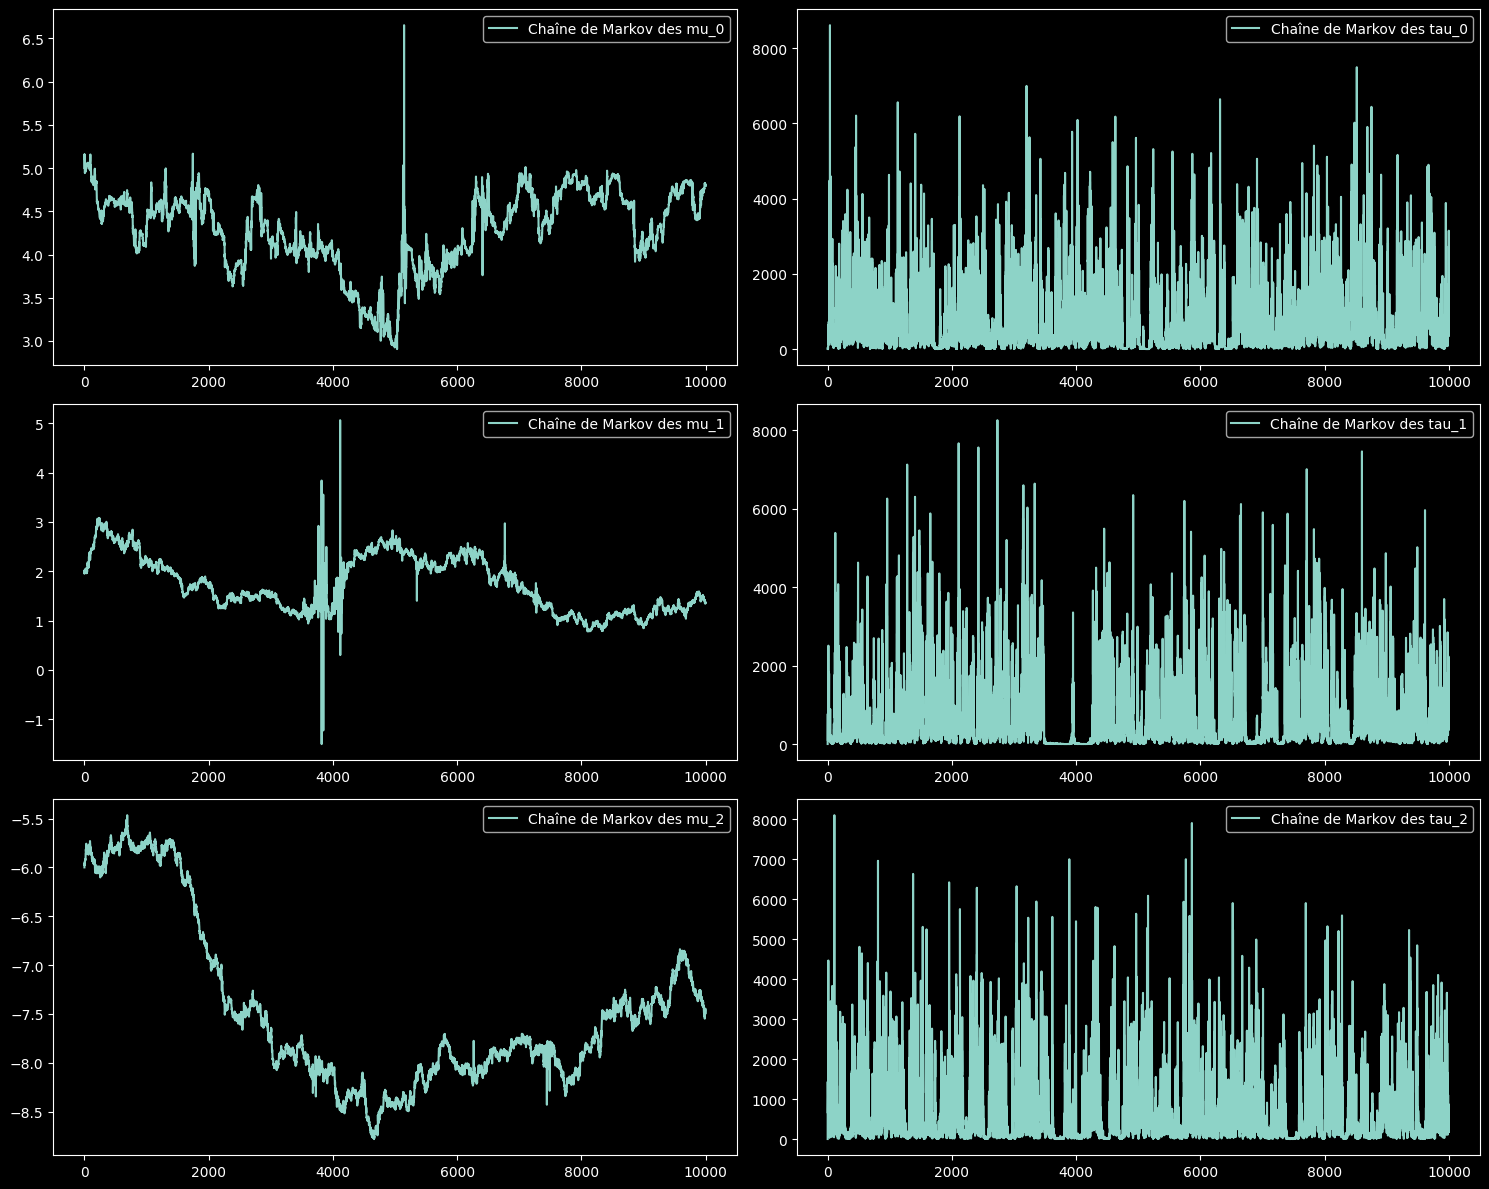

In [259]:
# Analyse des mu_k et tau_k
plt.style.use("dark_background")
n_k = chain_mu_k.shape[1]

plt.figure(figsize=(15, 12))

for i in range(n_k):
    # mu_k
    plt.subplot(n_k, 2, 2*i + 1)
    plt.plot(chain_mu_k[:, i], label=f'Chaîne de Markov des mu_{i}')
    plt.legend()

    # tau_k
    plt.subplot(n_k, 2, 2*i + 2)
    plt.plot(chain_tau_k[:, i], label=f'Chaîne de Markov des tau_{i}')
    plt.legend()

plt.tight_layout()
plt.show()

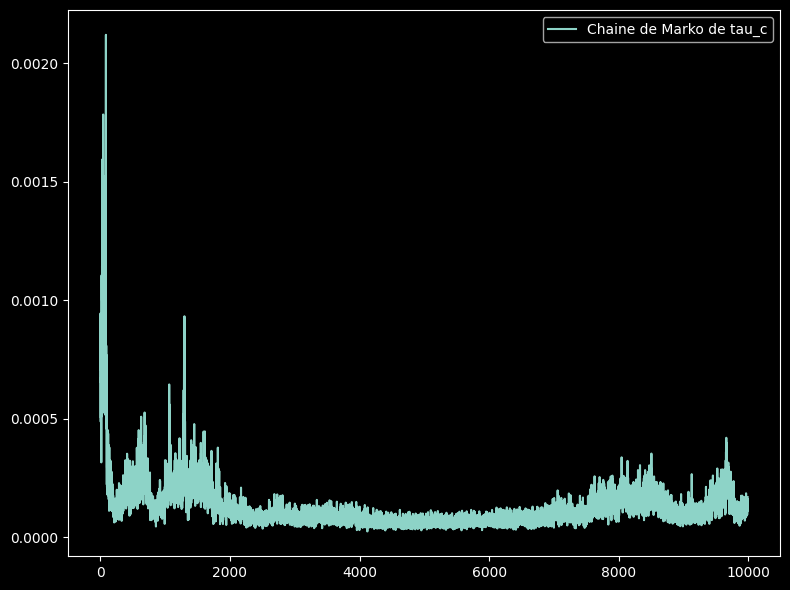

In [260]:
#Analyse de tau_c
plt.figure(figsize=(8,6))
plt.plot(chain_tau_C[10:], label='Chaine de Marko de tau_c')
plt.legend()
plt.tight_layout()
plt.show()

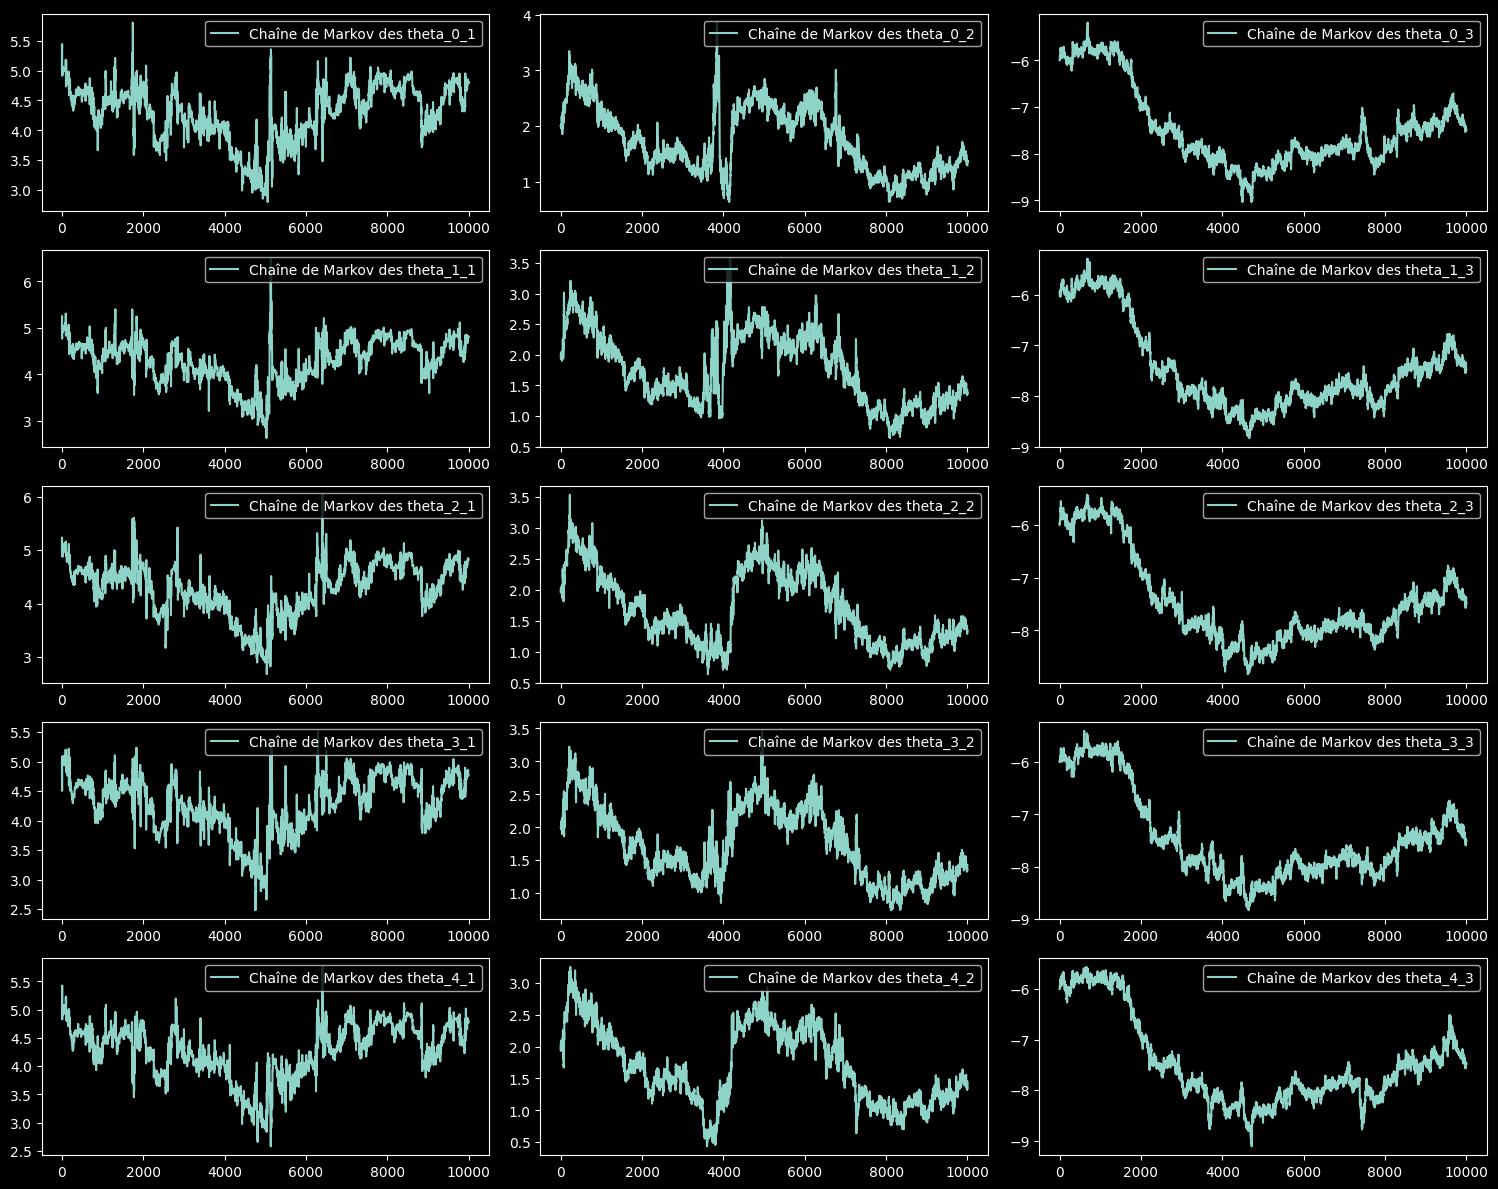

In [261]:
# Anlayse de thetas
n_k = chain_thetas.shape[1]

plt.figure(figsize=(15, 12))

for i in range(n_k):
    # theta_i_1
    plt.subplot(n_k, 3, 3*i + 1)
    plt.plot(chain_thetas[:,i][:,0], label=f'Chaîne de Markov des theta_{i}_1')
    plt.legend()

    # theta_i_2
    plt.subplot(n_k, 3, 3*i + 2)
    plt.plot(chain_thetas[:,i][:,1], label=f'Chaîne de Markov des theta_{i}_2')
    plt.legend()

    # theta_i_3
    plt.subplot(n_k, 3, 3*i + 3)
    plt.plot(chain_thetas[:,i][:,2], label=f'Chaîne de Markov des theta_{i}_3')
    plt.legend()

plt.tight_layout()
plt.show()